In [4]:
import pandas as pd

# Load the styles.csv and images.csv
styles_df = pd.read_csv('./styles.csv', on_bad_lines='skip')  # Skip bad lines
images_df = pd.read_csv('./images.csv')

In [5]:
styles_df.shape, images_df.shape

((44424, 10), (44446, 2))

In [6]:
# Merging the dataframes on the id and filename columns
merged_df = styles_df.merge(images_df, left_on='id', 
                            right_on=images_df.filename.str.split('.').str[0].astype(int), how='inner')

In [7]:
# Display the merged dataframe
merged_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg,http://assets.myntassets.com/v1/images/style/p...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg,http://assets.myntassets.com/v1/images/style/p...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg,http://assets.myntassets.com/v1/images/style/p...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg,http://assets.myntassets.com/v1/images/style/p...


In [14]:
merged_df.shape

(44424, 12)

In [10]:
# Impute missing values for baseColour and season with "Unknown"
merged_df['baseColour'].fillna('Unknown', inplace=True)
merged_df['season'].fillna('Unknown', inplace=True)

In [11]:
merged_df.isna().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour              0
season                  0
year                    1
usage                 317
productDisplayName      7
filename                0
link                    0
dtype: int64

In [13]:
# Drop rows with missing values in year, usage, and productDisplayName columns
merged_df.dropna(subset=['year', 'usage', 'productDisplayName']).shape

(44104, 12)

In [50]:
merged_df.isna().sum()

id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour              0
season                  0
year                    0
usage                 317
productDisplayName      0
filename                0
link                    0
dtype: int64

In [27]:
merged_df['year'].fillna(merged_df['year'].median(), inplace=True)

In [49]:
merged_df['productDisplayName'].fillna('Unknown', inplace=True)

In [54]:
merged_df[merged_df['usage'].isna()]['link'].iloc[0]

'http://assets.myntassets.com/v1/images/style/properties/Streetwear-Ash-Nail-Polish--31_21d33100dbf0e4b8bb0b33a980de469b_images.jpg'

In [57]:
merged_df['usage'].fillna('Casual Product', inplace=True)

In [58]:
merged_df.isna().sum()

id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
filename              0
link                  0
dtype: int64

# Missing Images

In [147]:
import os
folder_path = './images/'

In [148]:
filenames_content = [os.path.splitext(f)[0] for f in os.listdir(folder_path)\
                     if os.path.isfile(os.path.join(folder_path, f))]

In [149]:
drop_list = []
for i in merged_df['filename'].str.split('.').str[0]:
    if i not in filenames_content:
        print(i)
        drop_list.append(i)

In [150]:
drop_list = [int(val) for val in drop_list]

In [151]:
drop_list

[]

In [152]:
merged_df = merged_df[~merged_df['id'].isin(drop_list)]

In [154]:
merged_df[merged_df['id']==39401]

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link


In [168]:
# merged_df.to_csv("merged_data.csv")

# Fine Tuning

In [171]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import pandas as pd

In [172]:
class FashionDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.classes = self.dataframe['articleType'].unique().tolist()
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['filename']
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path)
        label = self.classes.index(self.dataframe.iloc[idx]['articleType'])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [173]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")
print(f"Using {device}")

Using mps


In [174]:
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [175]:
dataset = FashionDataset(csv_file="merged_data.csv", img_dir="./images", transform=data_transforms)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

In [176]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
num_classes = len(dataset.classes)
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [177]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [178]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

Epoch 1/10 - Loss: 0.9749
Epoch 2/10 - Loss: 0.4421
Epoch 3/10 - Loss: 0.3075
Epoch 4/10 - Loss: 0.2188
Epoch 5/10 - Loss: 0.1505
Epoch 6/10 - Loss: 0.1027
Epoch 7/10 - Loss: 0.0710
Epoch 8/10 - Loss: 0.0558
Epoch 9/10 - Loss: 0.0344
Epoch 10/10 - Loss: 0.0262


# Test Accuracy

In [179]:
from torch.utils.data import random_split

# Assuming dataset is already defined
train_size = len(dataset) - 1000
test_size = 1000
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


In [180]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the model on test images: {}%'.format(100 * correct / total))

Accuracy of the model on test images: 99.5%


# On a Single Image from the dataset

In [188]:
# Fetch a batch of images and labels
images, labels = next(iter(dataloader))

# Select the first image and label from this batch
image, label = images[0], labels[0]

In [189]:
# Ensure the model is in evaluation mode
model.eval()

# Move the image and model to the appropriate device (CPU or GPU)
image = image.unsqueeze(0).to(device)

# Get the predicted output
with torch.no_grad():
    output = model(image)
    _, prediction = torch.max(output, 1)
    predicted_class = dataset.classes[prediction[0].item()]

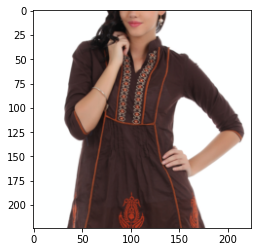

Actual Label: Kurtis
Predicted Label: Kurtis


In [190]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # Convert from Tensor image and display
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Display the image
imshow(images[0])
print(f"Actual Label: {dataset.classes[label]}")
print(f"Predicted Label: {predicted_class}")

# Unseen Image

In [203]:
from PIL import Image

# Replace 'path_to_image.jpg' with the path to your unseen image
image_path = './watch_test.jpeg'
unseen_image = Image.open(image_path).convert("RGB")

In [204]:
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

processed_image = data_transforms(unseen_image)
processed_image = processed_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

In [205]:
model.eval()  # Ensure the model is in evaluation mode

with torch.no_grad():
    output = model(processed_image)
    _, prediction = torch.max(output, 1)
    predicted_class = dataset.classes[prediction[0].item()]

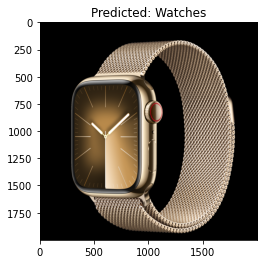

In [206]:
plt.imshow(unseen_image)
plt.title(f"Predicted: {predicted_class}")
plt.show()

# Saving the Model

In [207]:
torch.save(model.state_dict(), 'model_weights.pth')

# Recommendation model

In [259]:
class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        # Extract all layers up to the final fully connected layer
        self.features = nn.Sequential(*list(original_model.children())[:-1])
        
    def forward(self, x):
        x = self.features(x)
        return x.view(x.size(0), -1)  # Flatten the features


In [260]:
feature_extractor = FeatureExtractor(model).to(device)

In [271]:
feature_database = {}
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        features = feature_extractor(images).cpu().numpy()

        # Store features for individual images
        for idx, feature in enumerate(features):
            unique_img_id = batch_idx * dataloader.batch_size + idx
            feature_database[unique_img_id] = feature.reshape(1, -1)

In [275]:
def get_similar_images(input_img):
    with torch.no_grad():
        input_img = input_img.to(device)
        input_features = feature_extractor(input_img).cpu().numpy()
        input_features = input_features.reshape(1, -1)  # Explicitly reshape to 2D

    similarities = {}
    for img_id, features in feature_database.items():
        # Print the shapes for debugging
#         print("Input features shape:", input_features.shape)
#         print("Database features shape:", features.shape)
        
        features_reshaped = features.reshape(1, -1)  
        sim = cosine_similarity(input_features, features_reshaped)
        similarities[img_id] = sim[0][0]

    # Sort images by similarity
    sorted_images = sorted(similarities.keys(), key=lambda x: similarities[x], reverse=True)
    
    return sorted_images


In [301]:
# Load the image using PIL or similar
input_image_path = './watch_test.jpeg'
input_image = Image.open(input_image_path).convert("RGB")
input_image_tensor = data_transforms(input_image).unsqueeze(0)

recommended_items = get_similar_images(input_image_tensor)
top_10_items = recommended_items[:10]

In [302]:
top_10_items

[38597, 26797, 27567, 41110, 20583, 10352, 32240, 14721, 37112, 36470]

Image with ID 41110 not found at ./images/41110.jpg. Skipping...
Image with ID 37112 not found at ./images/37112.jpg. Skipping...


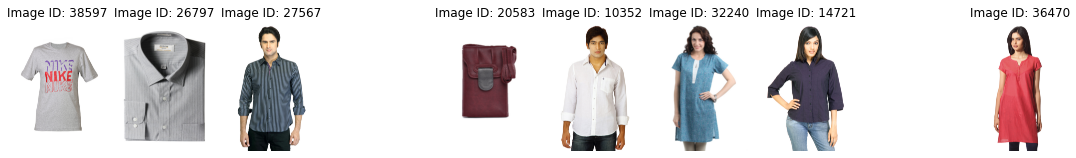

In [303]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def display_images(image_ids, folder_path='./images'):
    plt.figure(figsize=(15, 15))
    
    for idx, image_id in enumerate(image_ids, 1):
        image_path = os.path.join(folder_path, f"{image_id}.jpg")
        
        # Error handling for missing files
        if not os.path.exists(image_path):
            print(f"Image with ID {image_id} not found at {image_path}. Skipping...")
            continue

        img = Image.open(image_path)
        
        plt.subplot(1, len(image_ids), idx)
        plt.imshow(img)
        plt.title(f"Image ID: {image_id}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function
display_images(top_10_items)

Image with ID 41110 not found at ./images/41110.jpg. Skipping...
Image with ID 37112 not found at ./images/37112.jpg. Skipping...


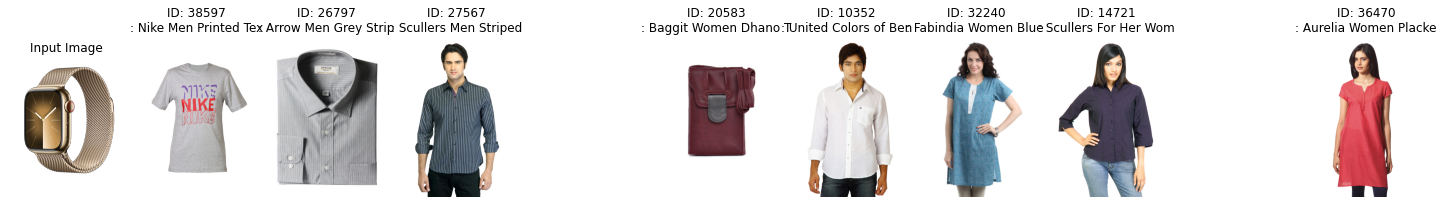

In [304]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

# Load the styles.csv data
# styles_df = pd.read_csv('/mnt/data/styles.csv', error_bad_lines=False)

def get_product_name(image_id):
    """Retrieve the product name based on the image ID."""
    return styles_df[styles_df['id'] == image_id]['productDisplayName'].values[0]

def display_images(input_image_path, image_ids, folder_path='./images'):
    plt.figure(figsize=(20, 20))
    
    # Display the input image first
    input_img = Image.open(input_image_path)
    plt.subplot(1, len(image_ids) + 1, 1)  # +1 for the input image
    plt.imshow(input_img)
    plt.title("Input Image")
    plt.axis('off')
    
    for idx, image_id in enumerate(image_ids, 2):  # Starting from 2 because 1 is for the input image
        image_path = os.path.join(folder_path, f"{image_id}.jpg")
        
        # Error handling for missing files
        if not os.path.exists(image_path):
            print(f"Image with ID {image_id} not found at {image_path}. Skipping...")
            continue

        img = Image.open(image_path)
        product_name = get_product_name(image_id)
        
        plt.subplot(1, len(image_ids) + 1, idx)
        plt.imshow(img)
        plt.title(f"ID: {image_id}\n: {product_name[:20]}")  # Displaying the first 30 characters of the name
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function with the path to the input image
display_images(input_image_path, top_10_items)


# Rough

In [224]:
# Let's extract one batch of images from the dataloader
sample_images, _ = next(iter(dataloader))

In [228]:
# 1. Move the model to the CPU
model.to('cpu')

# 2. Get the output from the avgpool layer of the model using sample images
with torch.no_grad():
    x = model.conv1(sample_images)
    x = model.bn1(x)
    x = model.relu(x)
    x = model.maxpool(x)

    x = model.layer1(x)
    x = model.layer2(x)
    x = model.layer3(x)
    x = model.layer4(x)

    sample_output = model.avgpool(x)

# 3. Print the shape of the output
print(sample_output.shape)

torch.Size([32, 2048, 1, 1])


In [250]:
feature_database[0].shape

(32, 2048)

In [256]:
input_image = sample_images[0].unsqueeze(0).to(device)
output = feature_extractor(input_image)

In [258]:
output.shape

torch.Size([1, 2048])

In [270]:
for k, v in feature_database.items():
    print(k, v.shape)

0 (32, 2048)
1 (32, 2048)
2 (32, 2048)
3 (32, 2048)
4 (32, 2048)
5 (32, 2048)
6 (32, 2048)
7 (32, 2048)
8 (32, 2048)
9 (32, 2048)
10 (32, 2048)
11 (32, 2048)
12 (32, 2048)
13 (32, 2048)
14 (32, 2048)
15 (32, 2048)
16 (32, 2048)
17 (32, 2048)
18 (32, 2048)
19 (32, 2048)
20 (32, 2048)
21 (32, 2048)
22 (32, 2048)
23 (32, 2048)
24 (32, 2048)
25 (32, 2048)
26 (32, 2048)
27 (32, 2048)
28 (32, 2048)
29 (32, 2048)
30 (32, 2048)
31 (32, 2048)
32 (32, 2048)
33 (32, 2048)
34 (32, 2048)
35 (32, 2048)
36 (32, 2048)
37 (32, 2048)
38 (32, 2048)
39 (32, 2048)
40 (32, 2048)
41 (32, 2048)
42 (32, 2048)
43 (32, 2048)
44 (32, 2048)
45 (32, 2048)
46 (32, 2048)
47 (32, 2048)
48 (32, 2048)
49 (32, 2048)
50 (32, 2048)
51 (32, 2048)
52 (32, 2048)
53 (32, 2048)
54 (32, 2048)
55 (32, 2048)
56 (32, 2048)
57 (32, 2048)
58 (32, 2048)
59 (32, 2048)
60 (32, 2048)
61 (32, 2048)
62 (32, 2048)
63 (32, 2048)
64 (32, 2048)
65 (32, 2048)
66 (32, 2048)
67 (32, 2048)
68 (32, 2048)
69 (32, 2048)
70 (32, 2048)
71 (32, 2048)
72

1211 (32, 2048)
1212 (32, 2048)
1213 (32, 2048)
1214 (32, 2048)
1215 (32, 2048)
1216 (32, 2048)
1217 (32, 2048)
1218 (32, 2048)
1219 (32, 2048)
1220 (32, 2048)
1221 (32, 2048)
1222 (32, 2048)
1223 (32, 2048)
1224 (32, 2048)
1225 (32, 2048)
1226 (32, 2048)
1227 (32, 2048)
1228 (32, 2048)
1229 (32, 2048)
1230 (32, 2048)
1231 (32, 2048)
1232 (32, 2048)
1233 (32, 2048)
1234 (32, 2048)
1235 (32, 2048)
1236 (32, 2048)
1237 (32, 2048)
1238 (32, 2048)
1239 (32, 2048)
1240 (32, 2048)
1241 (32, 2048)
1242 (32, 2048)
1243 (32, 2048)
1244 (32, 2048)
1245 (32, 2048)
1246 (32, 2048)
1247 (32, 2048)
1248 (32, 2048)
1249 (32, 2048)
1250 (32, 2048)
1251 (32, 2048)
1252 (32, 2048)
1253 (32, 2048)
1254 (32, 2048)
1255 (32, 2048)
1256 (32, 2048)
1257 (32, 2048)
1258 (32, 2048)
1259 (32, 2048)
1260 (32, 2048)
1261 (32, 2048)
1262 (32, 2048)
1263 (32, 2048)
1264 (32, 2048)
1265 (32, 2048)
1266 (32, 2048)
1267 (32, 2048)
1268 (32, 2048)
1269 (32, 2048)
1270 (32, 2048)
1271 (32, 2048)
1272 (32, 2048)
1273 (32